In [23]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-09 17:46:37--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv.2’

data.csv.2          100%[===================>]   1.41M  5.90MB/s    in 0.2s    

2023-10-09 17:46:37 (5.90 MB/s) - ‘data.csv.2’ saved [1475504/1475504]



In [24]:
import pandas as pd

In [25]:
required_cols = ['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP'] # list of required columns

df = pd.read_csv('data.csv', usecols=required_cols)
print(f'The selected columns are: {df.columns}')
df.head()


The selected columns are: Index(['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
       'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg',
       'MSRP'],
      dtype='object')


,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [26]:
df.columns = df.columns.str.replace(' ','_').str.lower()
for i in df.columns:
    if df[i].dtype == object:
        print(f'The column {i} is strings')
        df[i] = df[i].str.replace(' ','_').str.lower()

## print the count of rows which have null values
print(f'The number of rows with null values are: {df.isnull().any(axis=1).sum()}')
df = df.fillna(0)
print(f'The number of rows with null values are: {df.isnull().any(axis=1).sum()}')


The column make is strings
The column model is strings
The column transmission_type is strings
The column vehicle_style is strings
The number of rows with null values are: 98
The number of rows with null values are: 0


In [36]:
# Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`
df['above_average'] = df.msrp > df.msrp.mean()
df_mod = df.copy()
del df_mod['msrp']

In [43]:
from sklearn.model_selection import train_test_split
df_full_train,df_test = train_test_split(df_mod,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=(0.2/(0.6+0.2)),random_state=1)

print(
f"The size of df_train is: {len(df_train)}\n"
f"The size of df_val is: {len(df_val)}\n"
f"The size of df_test is: {len(df_test)}"
)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.head()

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


The size of df_train is: 7148
The size of df_val is: 2383
The size of df_test is: 2383


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [81]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc, roc_curve, roc_auc_score
cols = ['engine_hp','engine_cylinders','highway_mpg','city_mpg']

for i in cols:
    score = roc_auc_score(y_train,df_train[i].values)
    if score < 0.5:
        print(f'The roc_auc_score for {i} is: {roc_auc_score(y_train,-df_train[i].values)}')
    else:
        print(f'the roc_auc_score for {i} is: {score}')

the roc_auc_score for engine_hp is: 0.9171031265539011
the roc_auc_score for engine_cylinders is: 0.766116490165669
The roc_auc_score for highway_mpg is: 0.6330587871772013
The roc_auc_score for city_mpg is: 0.6734244643245233


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979


In [83]:

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

dv,model = train(df_train,y_train,C=1)
y_pred = predict(df_val,dv,model)
score = roc_auc_score(y_val,y_pred)

print(f'The roc_auc_score for validation set is: {round(score,3)}')

The roc_auc_score for validation set is: 0.977


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

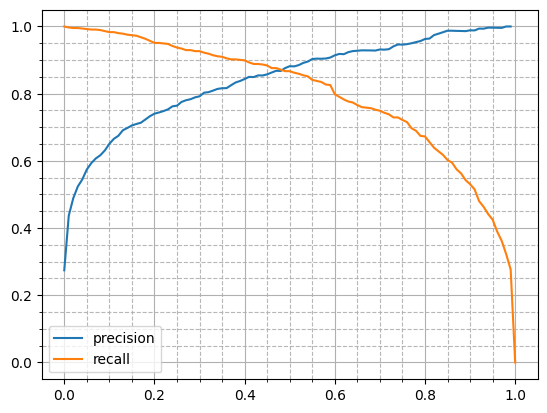

In [99]:
import numpy as np 
thresholds = np.linspace(0, 1, 101)
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred>=t)
    predict_negative = (y_pred<t)

    tp = (predict_positive & actual_positive ).sum()
    tn = (actual_negative & predict_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # Use a conditional expression to handle division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else None
    recall = tp / (tp + fn) if (tp + fn) > 0 else None

    scores.append((t, tp, fp, fn, tn, precision, recall))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores.head()

plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

# Display gridlines
plt.grid(True)  # Display major gridlines
plt.minorticks_on()  # Enable minor ticks
plt.grid( which='minor', linestyle='--', alpha=0.9)  # Display minor gridlines with dashed line style

plt.legend()

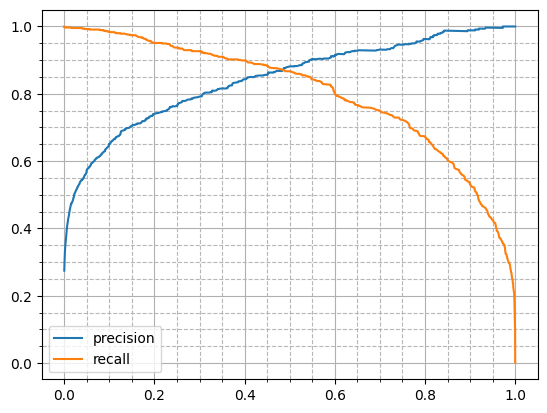

In [97]:
#plot precision and recall at different thresholds using sklearn
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
# get small gridlines
# Display gridlines
plt.grid(True)  # Display major gridlines
plt.minorticks_on()  # Enable minor ticks
plt.grid( which='minor', linestyle='--', alpha=0.9)  # Display minor gridlines with dashed line style

plt.legend()


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

The maximum f1_score is: 0.8743253662297611 and associated threshold is 0.5


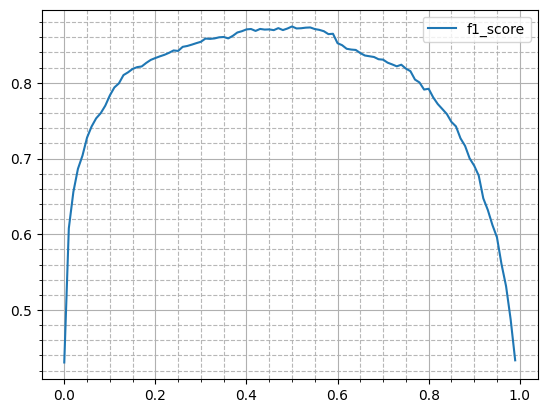

In [107]:
df_scores['f1_score'] = 2*df_scores.precision*df_scores.recall/(df_scores.precision+df_scores.recall)

plt.plot(df_scores.threshold, df_scores.f1_score, label='f1_score')
plt.grid(True)  # Display major gridlines
plt.minorticks_on()  # Enable minor ticks
plt.grid( which='minor', linestyle='--', alpha=0.9)  # Display minor gridlines with dashed line style

plt.legend()
print(f'The maximum f1_score is: {df_scores.f1_score.max()} and associated threshold is {df_scores.threshold[df_scores.f1_score.idxmax()]}')


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [ ]:
dv,model = train(df_train,y_train,C=1)
y_pred = predict(df_val,dv,model)
score = roc_auc_score(y_val,y_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Loop through each fold
for train_index, val_index in kf.split(df_full_train):
    df_train, df_val = df_full_train[train_index], df_full_train[val_index]
    y_train, y_val = y[train_index], y[val_index]

In [110]:
from sklearn.model_selection import KFold 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
#df_mod is same as df_full_train except that it contains
#the traget variable 'above_average'
for train_idx, val_idx in kfold.split(df_mod):
    df_train = df_mod.iloc[train_idx]
    df_val = df_mod.iloc[val_idx]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (1.0, np.mean(scores), np.std(scores)))

C=1.0 0.981 +- 0.002


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [112]:
from tqdm.auto import tqdm

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in tqdm([0.01, 0.1, 0.5, 10]):
    scores = []

    for train_idx, val_idx in kfold.split(df_mod):
        df_train = df_mod.iloc[train_idx]
        df_val = df_mod.iloc[val_idx]

        df_train = df_train.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
        
        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.954 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.978 +- 0.003
C=10 0.978 +- 0.004
